## ResNet18 Training (around 1000 seconds to complete for seed 42 with early stopping at epoch 13)

### Ensembles all seed predictions you provide with equal weights

#### Public score: 0.525, Private Score: 0.480

#### file name on Kaggle: resnet18_ensemble_TTA_3seeds_4.csv (Submitted on Dec 8th) -> This is submission 2 for the competition

In [1]:
import numpy as np
import pandas as pd
import pickle

from RetinaDataset import get_val_transforms, get_train_transforms, RetinaDataset, weighted_sampling, get_class_weights

from ResNetModel import train_model, load_resnet18_checkpoint, final_pred_ensemble, plot_training_curves

#### Load Data

In [2]:
with open("Data/train_data.pkl", "rb") as f:
    data = pickle.load(f)

images = data["images"] #(N, 28, 28, 3)
labels = np.array(data["labels"]).reshape(-1)

with open("Data/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

test_images = np.array(test_data["images"])

images.shape, labels.shape, test_images.shape

((1080, 28, 28, 3), (1080,), (400, 28, 28, 3))

### Split data, apply different transforms, define weighted loss function

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

device = "cpu"

#Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=2596)

#TRANSFORM Splits (Augment size to 96 by 96 pixels)
train_tf = get_train_transforms()
val_tf = get_val_transforms()


#Load TRANSFORMED Datasets (Wrapped Data inside Torch Dataset)
#train data augmentation: flip, rotate, vary brightness and contrast

train_ds = RetinaDataset(X_train, y_train, train_tf)

#validation + test: minimal augmentation: just resize & norm
#we want validation and test data to resemble real-like conditions

val_ds   = RetinaDataset(X_val,   y_val,   val_tf)
test_ds = RetinaDataset(test_images, transform=val_tf)


#Weighted SAMPLING + WEIGHTED LOSS to handle class imbalance
#Rare classes sampled more often

sampler = weighted_sampling(y_train)

#Define weighted cross-entropy loss function (weighted gradients)

class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

#LOADERS use samplee only on train data
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)

#validation + test data simulates real-world and we don't shuffle

test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# Train ResNet18 model in 2 Phases
## phase 1 trains last layer only; phase 2 trains the whole network
### Phase 1 lasts 5 epochs (warmup), Phase 2 can go up to 25 epochs with early stopping enabled


TRAINING RESNET18 with SEED 42

Phase 1 — Epoch 1/5
Train Acc: 0.221 | Train Loss: 1.557
Val   Acc: 0.074 | Val   Loss: 2.066

Phase 1 — Epoch 2/5
Train Acc: 0.278 | Train Loss: 1.444
Val   Acc: 0.120 | Val   Loss: 1.949

Phase 1 — Epoch 3/5
Train Acc: 0.323 | Train Loss: 1.324
Val   Acc: 0.194 | Val   Loss: 1.730

Phase 1 — Epoch 4/5
Train Acc: 0.383 | Train Loss: 1.216
Val   Acc: 0.208 | Val   Loss: 1.864

Phase 1 — Epoch 5/5
Train Acc: 0.348 | Train Loss: 1.310
Val   Acc: 0.171 | Val   Loss: 1.846

Phase 2 — Epoch 1/25
Train Acc: 0.397 | Train Loss: 1.239
Val Acc: 0.296 | Val Loss: 1.646

Phase 2 — Epoch 2/25
Train Acc: 0.497 | Train Loss: 0.986
Val Acc: 0.231 | Val Loss: 1.861

Phase 2 — Epoch 3/25
Train Acc: 0.574 | Train Loss: 0.786
Val Acc: 0.394 | Val Loss: 1.689

Phase 2 — Epoch 4/25
Train Acc: 0.593 | Train Loss: 0.716
Val Acc: 0.398 | Val Loss: 1.728

Phase 2 — Epoch 5/25
Train Acc: 0.666 | Train Loss: 0.582
Val Acc: 0.394 | Val Loss: 1.756

Phase 2 — Epoch 6/25
Train Acc: 

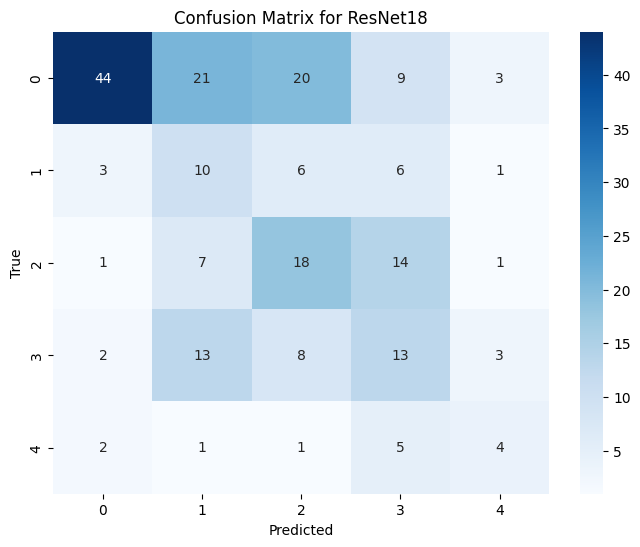

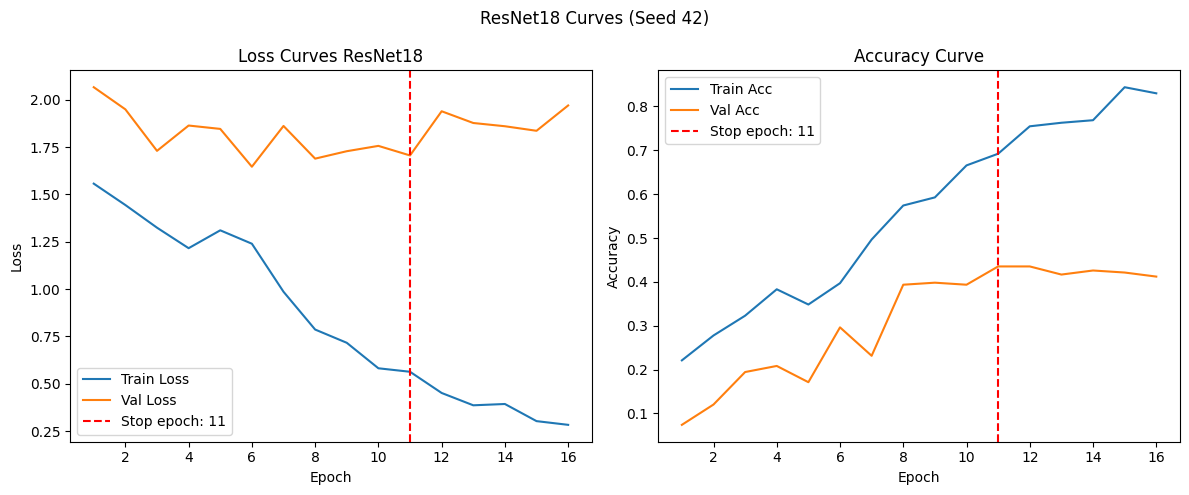

In [4]:
#SEED = 2596
#SEED = 1206
SEED = 42

#Train model and obtain final preds and metrics
eval_epoch, final_preds, final_labels = train_model(SEED, f"resnet_seed_{SEED}.pth", train_loader, val_loader, criterion)

plot_training_curves(eval_epoch, title=f"ResNet18 Curves (Seed {SEED})")

### Load saved models

In [ ]:
#Uncomment the model or models you wish to load
#Due to size constrains, we only upload 1 model to Gradescope ()

models_ensemble_dict = [
    #load_resnet18_checkpoint("resnet_seed_2596.pth"),
    load_resnet18_checkpoint("resnet_seed_42.pth"),
    #load_resnet18_checkpoint("resnet_seed_1206.pth"),
]

### Average prediction of ensembles

In [6]:
#Average the predictions of all models in the models_ensemble_dict and returns it.

final_preds = final_pred_ensemble(models_ensemble_dict, test_loader)

#Display first 5 preds
final_preds.shape, final_preds[:5]

((400,), array([0, 1, 0, 1, 0]))

#### save to csv

In [7]:
submission = pd.DataFrame({
    "ID": np.arange(1, len(final_preds) + 1),
    "label": final_preds
})

submission.to_csv("resnet18_ensemble_3seeds.csv", index=False)
print(f"Saved ensemble csv")

Saved ensemble csv
